# FUEGO

FUEGO is a feature-pivot method that uses a sliding time window mechanism to detect when something happens in real-time.
Normally, Topic Detection and Tracking (TDT) approaches try to identify when _something_ happens.
FUEGO is slightly different: it receives as part of its inputs a list of streams.
Each stream represents a type of development, or closely-related develpoments, and identifies when any of these developments occur.

The idea behind FUEGO is that we know in advance what kind of developments can happen, so we can keep an eye out for them.
This has several advantages, such as:

- We can deal with spam more easily.
- Since the streams are so focused, we can do away with clustering, allowing for a finer granularity.

This notebook goes through FUEGO's steps:

1. Tweet filtering
2. Deciding whether a stream might have developments
3. Scoring words (also known as nutrition)
4. Detecting whether any words are breaking

Set up the notebook with details about the dataset.
This notebook focuses on the match between Southampton FC and Arsenal FC, which the latter won 2-0.
During the match, there was also one red card and two bookings.

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patheffects as pe
import json
import math
import os
import statistics
import sys

sys.path.append(os.path.expanduser("~/GitHub/EvenTDT"))
sys.path.append(os.path.expanduser("~/GitHub/multiplex-plot"))
sys.path = list(set(sys.path))

from eventdt.objects.exportable import Exportable
from eventdt.queues import Queue
from eventdt.queues.consumers.algorithms import FUEGOConsumer
from eventdt import twitter
from eventdt.twitter import corpus

from multiplex import drawable

understanding = os.path.expanduser('~/DATA/c6-tdt/data/#SCOCZE/understanding.json')
file = os.path.expanduser('~/DATA/c6-tdt/data/#SCOCZE/event.json')

split, track = [ 'goal', 'score', 'conced', 'equalis', 'offsid', 'assist' ], 'schick'

Set up the visualization style to use in this notebook.

In [2]:
plt.style.use(os.path.join(os.getcwd(), '../modern-custom.style'))
style = { 'linewidth': 3, 'with_legend': True, 'zorder': 1,
          'path_effects': [ pe.Stroke(linewidth=6, foreground='C4'), pe.Normal() ] }
marker_style = { 'marker': 'o', 'markersize': 9 }
scatter_style = { 's': marker_style['markersize'] ** 2, 'zorder': 2 }
annotation_marker_style = dict(marker_style)
annotation_marker_style.update({ 'markersize': 13, 'markeredgewidth': 3, 'markeredgecolor': 'C4' }) # 18-4=14 (markersize)
line_style = { 'alpha': 0.3, 'linestyle': '--', 'linewidth': 1 }
annotation_style = { 'fontsize': 'smaller',
                     'va': 'center', 'alpha': 0.8, 'facecolor': '#ffffff99' }

faded_style = dict(style)
faded_style.update({ 'color': 'C5' })
highlight_style = dict(style)
highlight_style.update({ 'color': 'C0' })

FUEGO's process is split into two:

1. The understanding period precedes the event. During this time, FUEGO captures some information about the event. It uses this data to construct a TF-ICF term-weighting scheme, which it later uses to weight terms.
2. The actual processing period, or the event period, is when the action happens. FUEGO's job at this point is to identify when something new and noteworthy happens.

## Understanding Period

FUEGO's understanding period is very simple.
Assuming that the dataset has already been collected, FUEGO constructs a TF-ICF term-weighting scheme from this corpus.
The point of this term-weighting scheme is that the algorithm will be able to understand, later, how often we can expect to observe different words.

For example, if the word _Arsenal_ is very common before _and_ during the event, then it probably describes something very general about an event.
On the contrary, if the word _goal_ is rarely mentioned before the event, but suddenly people start talking about it during the event, then it's like that the word represents a development.

In [3]:
queue = Queue()
consumer = FUEGOConsumer(queue)
with open(understanding) as f:
    for line in f:
        data = json.loads(f.readline())
        queue.enqueue(data)
    scheme = (await consumer.understand(max_inactivity=10))['scheme']

consumer = FUEGOConsumer(Queue(), scheme=scheme)

12:29:21: INFO: Window size:      60
12:29:21: INFO: Burst:            [0.5, 0.2]
12:29:21: INFO: Minimum volume:   15
12:29:21: INFO: Threshold:        DynamicThreshold.MEAN
12:29:38: INFO: TF-IDF constructed with 8695 documents
12:29:38: INFO: Window size:      60
12:29:38: INFO: Burst:            [0.5, 0.2]
12:29:38: INFO: Minimum volume:   15
12:29:38: INFO: Threshold:        DynamicThreshold.MEAN


## Event Period

### 1. Filtering

FUEGO filters tweets aggressively. It uses rules from FIRE and ELD. FIRE's rules are:

1. The tweet has to be in English,

2. The tweet must contain no more than 2 hashtags,

3. The tweet's author must have favorited at least one tweet, and

4. The tweet's author must have at least one follower for every thousand tweets they've published.

ELD's rule is:

5. The biography of the tweet's author cannot be empty because that is indicative of bots.

6. The tweet may have no more than one URL. FUEGO is harsher, and rejects all tweets with URLs in them.

We'll be doing a lot of counting in this notebook.
Before going through FUEGO's process during the event period, we define a function that we'll use to count the number of tweets.

In [4]:
def volume(bin, track=None, filtered=False, *args, **kwargs):
    """
    Count the number of tweets in the given bin.

    :param bin: A bin containing a list of tweets to count.
    :type bin: list of dict
    :param track: The keyword to track.
                  These are not used in this function.
    :type track: None or str
    :param filtered: A boolean indicating whether to filter tweets using FUEGO's rules.
    :type filtered: bool

    :return: The number of tweets in the bin.
    :rtype: int
    """
    
    return len(bin) if not filtered else len(consumer._filter_tweets(bin))

with open(file) as f:
    total = corpus.aggregate(f, agg=volume, bin_size=60)
    f.seek(0)
    filtered = corpus.aggregate(f, agg=volume, bin_size=60, filtered=True)

The original event is shown below, with annotations of the most important moments during the match.
Other important moments in TDT, not shown here, include the start and end of each half, two yellow cards and a red card.

Note that when something big happens, there's a spike in volume.
Those spikes are what feature-pivot approaches attempt to extract.

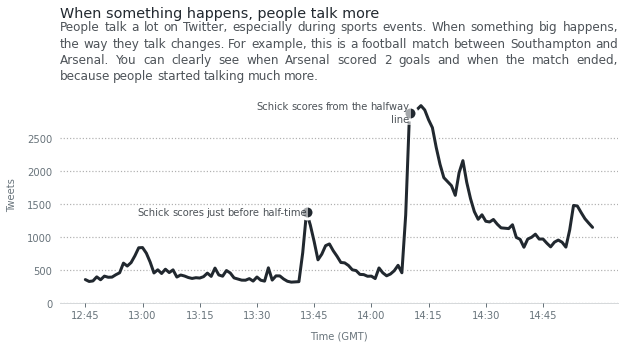

In [5]:
"""
Prepare the data.
"""
term = '*'
timestamps = sorted(total.keys())[1:-1]
term_volume = [ total.get(timestamp, { }).get(term) for timestamp in timestamps ]
annotations = {
    (timestamps.index(timestamps[58]), term_volume[timestamps.index(timestamps[58])]): 'Schick scores just before half-time',
    (timestamps.index(timestamps[85]), term_volume[timestamps.index(timestamps[85])]): 'Schick scores from the halfway line',
}

"""
Draw the visualization.
"""
plt.style.use(os.path.join(os.getcwd(), '..', "modern-custom.style"))
plt.style.reload_library()
figure = plt.figure(figsize=(10,4))
viz = drawable.Drawable(figure)
viz.set_xlabel('Time (GMT)')
viz.set_ylabel('Tweets')
viz.draw_time_series(range(len(term_volume)), term_volume, **style)

"""
Annotate the visualization.
"""
for (x, y), annotation in annotations.items():
    viz.annotate(annotation, (x - 45, x), y, marker=annotation_marker_style,
                 align='right', color='C0', **annotation_style)

"""
Finalize the visualization.
"""
viz.set_title('When something happens, people talk more', loc='left')
viz.set_caption("""People talk a lot on Twitter, especially during sports events.
                   When something big happens, the way they talk changes.
                   For example, this is a football match between Southampton and Arsenal.
                   You can clearly see when Arsenal scored 2 goals and when the match ended, because people started talking much more.""",
                align='justify')
xticks = [ i for i, timestamp in enumerate(timestamps) if not timestamp % (60 * 15) ]
viz.set_xticks(xticks)
viz.set_xticklabels([ datetime.utcfromtimestamp(timestamps[x]).strftime('%H:%M') for x in xticks ])
viz.set_ylim(0, math.ceil(max(term_volume) * 1.1))
viz.set_yticks(list(range(0, math.ceil(max(term_volume)), 500)))
viz.set_axisbelow(True)
# viz.savefig('exports/fuego-1.png', dpi=300, bbox_inches='tight')
viz.show()

Although FUEGO adopts a rather aggressive filtering strategy, even after removing tweets, the most important developments are still distinguished.
The next visualization shows how many tweets remain after FUEGO filters out tweets.

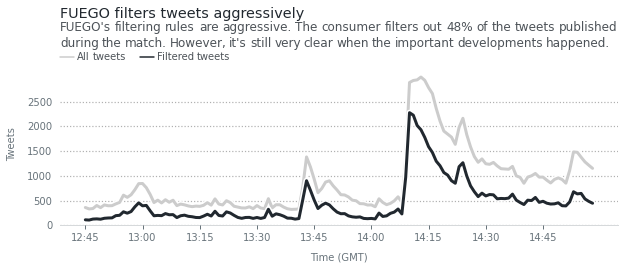

In [6]:
"""
Prepare the data.
"""
term = '*'
timestamps = sorted(total.keys())[1:-1]
term_volume = [ total.get(timestamp, { }).get(term) for timestamp in timestamps ]
filtered_volume = [ filtered.get(timestamp, { }).get(term) for timestamp in timestamps ]

"""
Draw the visualization.
"""
plt.style.use(os.path.join(os.getcwd(), '..', "modern-custom.style"))
plt.style.reload_library()
figure = plt.figure(figsize=(10,3))
viz = drawable.Drawable(figure)
viz.set_xlabel('Time (GMT)')
viz.set_ylabel('Tweets')
viz.draw_time_series(range(len(term_volume)), term_volume, f"All tweets", **faded_style)
viz.draw_time_series(range(len(term_volume)), filtered_volume, f"Filtered tweets", **style)

"""
Finalize the visualization.
"""
viz.set_title('FUEGO filters tweets aggressively', loc='left')
viz.set_caption(f"""FUEGO's filtering rules are aggressive.
                    The consumer filters out { round(100 - sum(filtered_volume)/sum(term_volume) * 100) }% of the tweets published during the match.
                    However, it's still very clear when the important developments happened.""",
                align='justify')
xticks = [ i for i, timestamp in enumerate(timestamps) if not timestamp % (60 * 15) ]
viz.set_xticks(xticks)
viz.set_xticklabels([ datetime.utcfromtimestamp(timestamps[x]).strftime('%H:%M') for x in xticks ])
viz.set_ylim(0, math.ceil(max(term_volume) * 1.1))
viz.set_yticks(list(range(0, math.ceil(max(term_volume)), 500)))
viz.set_axisbelow(True)
# viz.savefig('exports/fuego-2.png', dpi=300, bbox_inches='tight')
viz.show()

### 2. Streaming

These peaks are important because they tell us what happened, but the peaks in the overall volume only describe the very important developments.
Therefore FUEGO splits the overall volume into multiple streams.

Streams may accept tweets that contain any number of words.
Furthermore, FUEGO can send one tweet to multiple streams.
This notebook focuses only on one stream: the tweets that mention a group of words that relate to fouls.

First, we load the tweets that mention any of the words _card_, _yellow_, _book_ and _foul_ in the dataset.

In [7]:
documents = [ ]
with open(file) as f:
    for line in f:
        tweet = json.loads(line)
        if consumer._validate_tweet(tweet):
            document = consumer._to_documents([ tweet ])[0]
            
            # save this document as relevant if it contains the term
            if any( document.dimensions[word] for word in split ):
                documents.append(document)

Then, we create the FUEGO consumer, which consumes tweets using FUEGO's process.
We send the relevant tweets that mention the word _yellow_ to it.

In [8]:
consumer = FUEGOConsumer(Queue(), scheme, damping=0)
consumer._update_volume(documents)
volume = consumer.volume.all()

# so far, the documents are split per second, so we split them into minutes.
stream = dict.fromkeys(total.keys(), 0)
for timestamp, tweets in volume.items():
    stream[timestamp - timestamp % 60] += tweets

12:30:43: INFO: Window size:      60
12:30:43: INFO: Burst:            [0.5, 0.2]
12:30:43: INFO: Minimum volume:   15
12:30:43: INFO: Threshold:        DynamicThreshold.MEAN


As expected, the volume within the stream is much more subdued.
Looking at the bigger picture, the volume of the stream is also insignificant.
You can't even see any proper peaks!
However, if we isolate the volume of the stream, peaks re-emerge.

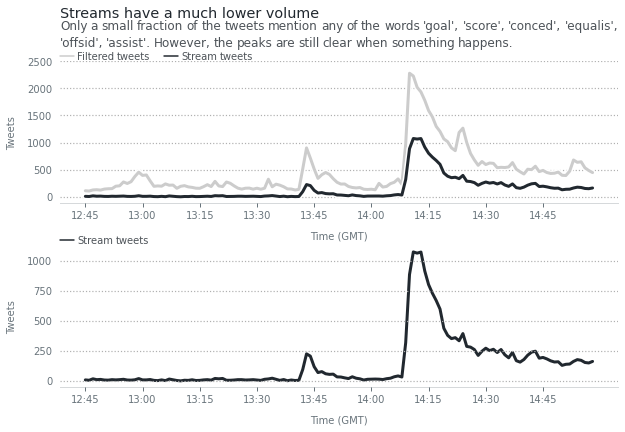

In [9]:
"""
Prepare the data.
"""
term = '*'
timestamps = sorted(filtered.keys())[1:-1]
filtered_volume = [ filtered.get(timestamp, { }).get(term) for timestamp in timestamps ]
stream_volume = [ stream.get(timestamp, { }) for timestamp in timestamps ]

"""
Set up the visualization.
"""
plt.style.use(os.path.join(os.getcwd(), '..', "modern-custom.style"))
plt.style.reload_library()
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,6))

"""
Set up general settings for both plots.
"""
xticks = [ i for i, timestamp in enumerate(timestamps) if not timestamp % (60 * 15) ]

"""
Draw the isolated stream tweets.
"""
viz = drawable.Drawable(figure, ax2)
viz.set_xlabel('Time (GMT)')
viz.set_ylabel('Tweets')
viz.draw_time_series(range(len(stream_volume)), stream_volume, f"Stream tweets", **style)

viz.set_xticks(xticks)
viz.set_xticklabels([ datetime.utcfromtimestamp(timestamps[x]).strftime('%H:%M') for x in xticks ])
viz.set_yticks(list(range(0, math.ceil(max(stream_volume)), 250)))

"""
Draw the stream as a subset of all tweets.
"""
viz = drawable.Drawable(figure, ax1)
viz.set_xlabel('Time (GMT)')
viz.set_ylabel('Tweets')
viz.draw_time_series(range(len(filtered_volume)), filtered_volume, f"Filtered tweets", **faded_style)
viz.draw_time_series(range(len(stream_volume)), stream_volume, f"Stream tweets", **style)

viz.set_xticks(xticks)
viz.set_xticklabels([ datetime.utcfromtimestamp(timestamps[x]).strftime('%H:%M') for x in xticks ])
viz.set_yticks(list(range(0, math.ceil(max(term_volume)), 500)))

"""
Finalize the visualization.
"""
viz.set_title('Streams have a much lower volume', loc='left')
viz.set_caption(f"""Only a small fraction of the tweets mention any of the words '{ "', '".join(split) }'.
                    However, the peaks are still clear when something happens.""",
                align='justify')
viz.set_axisbelow(True)
# viz.savefig('exports/fuego-3.png', dpi=300, bbox_inches='tight')
viz.show()

In reality, FUEGO does not use the raw volume, but dampens the importance of old retweets.
Normally, old retweets talk about something that happened in the past.
The idea is that these old retweets should not influence what we think is happening now.

\begin{equation}
damp_t =
\begin{cases}
    e^{-\lambda \frac{t_r - t_o}{60}} & \text{if } t \text{ is a retweet}\\
    0                                 & \text{otherwise}
\end{cases}
\end{equation}

Here, $t_r$ is the timestamp when the user retweeted the tweet, and $t_o$ is the timestamp when the original tweet was published.
Note that with this equation, the score never reaches 0, and the maximum score is 1.
That looks something like the following.

In [10]:
def damp(x, l):
    """
    Calculate the damping score of the retweet of a tweet published x seconds earlier.
    
    :param x: The number of seconds that have elapsed since the original tweet was published.
    :type x: int
    :param l: The lambda, or the co-efficient that influences how much damping is applied.
              The higher lambda, the more old retweets are penalized.
    :type l: float
    
    :return: The damping factor to apply to the tweet.
    :rtype: float
    """
    
    return math.exp(- l * x / 60)

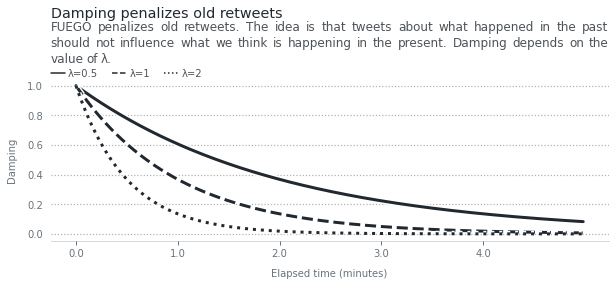

In [11]:
"""
Prepare the data.
"""
x = range(0, 60 * 5)
y05 = [ damp(_x, 0.5) for _x in x]
y1 = [ damp(_x, 1) for _x in x]
y2 = [ damp(_x, 2) for _x in x]

"""
Draw the visualization.
"""
plt.style.use(os.path.join(os.getcwd(), '..', "modern-custom.style"))
plt.style.reload_library()
figure = plt.figure(figsize=(10,3))
viz = drawable.Drawable(figure)
viz.set_xlabel('Elapsed time (minutes)')
viz.set_ylabel('Damping')
viz.draw_time_series(x, y05, f"λ=0.5", color='C0', **style)
viz.draw_time_series(x, y1, f"λ=1", color='C0', linestyle='--', **style)
viz.draw_time_series(x, y2, f"λ=2", color='C0', linestyle=':', **style)

"""
Finalize the visualization.
"""
viz.set_title('Damping penalizes old retweets', loc='left')
viz.set_caption(f"""FUEGO penalizes old retweets.
                    The idea is that tweets about what happened in the past should not influence what we think is happening in the present.
                    Damping depends on the value of λ.""",
                align='justify')
viz.set_xticks(range(0, max(x) + 1, 60))
viz.set_xticklabels([ _x / 60 for _x in x if not _x % 60 ])
viz.set_axisbelow(True)
# viz.savefig('exports/fuego-4.png', dpi=300, bbox_inches='tight')
viz.show()

In FUEGO, we use a λ value of 0.5.

In [12]:
consumer = FUEGOConsumer(Queue(), scheme, damping=0.5)
consumer._update_volume(documents)
volume = consumer.volume.all() # so far, the documents are split per minute
damped_stream = dict.fromkeys(total.keys(), 0)
for timestamp, tweets in volume.items():
    damped_stream[timestamp - timestamp % 60] += tweets

12:30:45: INFO: Window size:      60
12:30:45: INFO: Burst:            [0.5, 0.2]
12:30:45: INFO: Minimum volume:   15
12:30:45: INFO: Threshold:        DynamicThreshold.MEAN


The next visualization shows the effects of damping the stream.
In this isolated stream, the effect is not so pronounced because the peaks are already well-defined.
In more voluminous streams, the 'event shadow' that follows developments almost disappears.

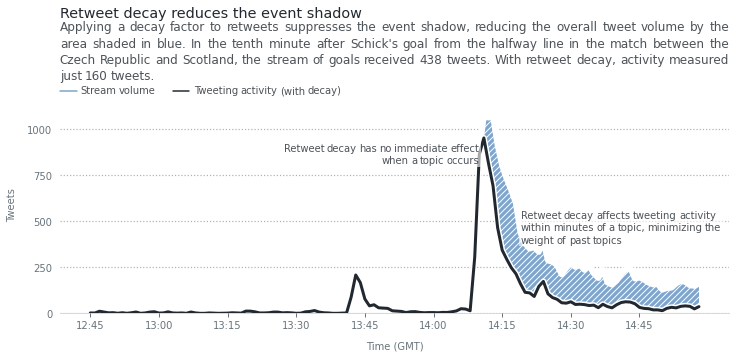

In [13]:
"""
Prepare the data.
"""
term = '*'
timestamps = sorted(stream.keys())[1:-1]
stream_volume = [ stream.get(timestamp, { }) for timestamp in timestamps ]
damped_stream_volume = [ damped_stream.get(timestamp, { }) for timestamp in timestamps ]
shadow = max(annotations.keys(), key=lambda key: key[0])[0]
goal_shadow = (shadow-1, shadow+9)
shadow = (0, len(damped_stream_volume) - 1)

_annotations = {
    (timestamps.index(timestamps[85]), damped_stream_volume[timestamps.index(timestamps[85])]): 
        { 'text': "Retweet decay has no immediate effect when a topic occurs",
          'style': { 'align': 'right' }},
    (timestamps.index(timestamps[94]), damped_stream_volume[timestamps.index(timestamps[89])]): 
        { 'text': "Retweet decay affects tweeting activity within minutes of a topic, minimizing the weight of past topics",
          'style': { 'align': 'left' } }
}

"""
Draw the visualization.
"""
plt.style.use(os.path.join(os.getcwd(), '..', "modern-custom.style"))
plt.style.reload_library()
figure = plt.figure(figsize=(12,4))
viz = drawable.Drawable(figure)
viz.set_xlabel('Time (GMT)')
viz.set_ylabel('Tweets')
_faded_style = dict(faded_style)
_faded_style.update({ 'alpha': 1, 'color': 'C1', 'linestyle': '-', 'linewidth': 0 })
viz.draw_time_series(range(len(stream_volume)), stream_volume, f"Stream volume", **_faded_style)
viz.draw_time_series(range(len(damped_stream_volume)), damped_stream_volume, f"Tweeting activity (with decay)", **style)
# the next line used when highlighting a part of the shadow
# viz.fill_between(range(*shadow), stream_volume[shadow[0]:shadow[1]], damped_stream_volume[shadow[0]:shadow[1]],
#                  hatch='////', color='C3', linewidth=2, edgecolor='C5')
# the next line used when highlighting all shadows
viz.fill_between(range(len(damped_stream_volume)), stream_volume, damped_stream_volume,
                 hatch='////', color='C1', alpha=1, linewidth=0, edgecolor='C4')

"""
Annotate the visualization.
"""
for (x, y), annotation in _annotations.items():
    text, _style = annotation['text'], annotation['style']
    _annotation_style = dict(annotation_style)
    _annotation_style.update(_style)
    _x = (x, x + 45) if _annotation_style.get('align', 'left') == 'left' else (x - 45, x)
    viz.annotate(text, _x, y, **_annotation_style)

"""
Finalize the visualization.
"""
xticks = [ i for i, timestamp in enumerate(timestamps) if not timestamp % (60 * 15) ]
viz.set_xticks(xticks)
viz.set_xticklabels([ datetime.utcfromtimestamp(timestamps[x]).strftime('%H:%M') for x in xticks ])
viz.set_ylim(0, math.ceil(max(stream_volume) * 1.1))
viz.set_yticks(list(range(0, math.ceil(max(stream_volume)), 250)))
viz.set_axisbelow(True)
viz.set_title('Retweet decay reduces the event shadow', loc='left')
viz.set_caption(f"""Applying a decay factor to retweets suppresses the event shadow, reducing the overall tweet volume by the area shaded in blue.
                    In the tenth minute after Schick's goal from the halfway line in the match between the Czech Republic and Scotland, the stream of goals received { int(stream_volume[goal_shadow[1]]) } tweets.
                    With retweet decay, activity measured just { int(damped_stream_volume[goal_shadow[1]]) } tweets.""",
                align='justify')
viz.savefig('../exports/6.2-retweet-decay.png', dpi=300, bbox_inches='tight')